# Исследование надежности заемщиков

Заказчик — кредитный отдел банка. Входные данные от банка — статистика о платёжеспособности клиентов

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Были предоставлены следующие данные:

`children` — количество детей в семье

`days_employed` — общий трудовой стаж в днях

`dob_years` — возраст клиента в годах

`education` — уровень образования клиента

`education_id` — идентификатор уровня образования

`family_status` — семейное положение

`family_status_id` — идентификатор семейного положения

`gender` — пол клиента

`income_type` — тип занятости

`debt` — имел ли задолженность по возврату кредитов

`total_income` — ежемесячный доход

`purpose` — цель получения кредита

**Наша задача:** выяснить влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

## Получение данных

In [3]:
# импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [10]:
# прочитаем csv-файл
data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [12]:
# выведем первые строки датасета
print(data.head(20))

    children  days_employed  dob_years            education  education_id  \
0          1   -8437.673028         42               высшее             0   
1          1   -4024.803754         36              среднее             1   
2          0   -5623.422610         33              Среднее             1   
3          3   -4124.747207         32              среднее             1   
4          0  340266.072047         53              среднее             1   
5          0    -926.185831         27               высшее             0   
6          0   -2879.202052         43               высшее             0   
7          0    -152.779569         50              СРЕДНЕЕ             1   
8          2   -6929.865299         35               ВЫСШЕЕ             0   
9          0   -2188.756445         41              среднее             1   
10         2   -4171.483647         36               высшее             0   
11         0    -792.701887         40              среднее             1   

In [14]:
# получим основную информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


У нас 21525 записей о клиентах банка, в каждой из которых 12 параметров, по которым оценивают клиента.

## Предобработка данных

### Удаление пропусков

Выведем количество пропущенных значений для каждого столбца

In [20]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения. Один из них — `days_employed`. Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнять пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [23]:

# Найдем уникальные значения типа занятости, чтобы по этим группам посчитать медианные значения.
income_types = data['income_type'].unique()
income_types = sorted(income_types)
# Считаем медианные значения в столбце `total_income`.
income_medians = data.groupby('income_type')['total_income'].median()
# Заменим пропуски в столбце total_income медианными значениями
for incomes in income_types:
    data.loc[(data['income_type'] == incomes) & (data['total_income'].isna()), 'total_income']= \
    data.loc[data['income_type'] == incomes, 'total_income'].median()


### Обработка аномальных значений

В данных могут встречаться аномалии — значения, которые не отражают действительность и появились по какой-то ошибке. Таким артефактом будет отрицательное количество дней трудового стажа в столбце `days_employed`. 

In [26]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.

In [29]:
# Посчитаем медианные значения стажа по каждому типу занятости
days_employed_medians = data.groupby('income_type')['days_employed'].median()
days_employed_medians

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставим их как есть.

Выведите перечень уникальных значений столбца `children`.

In [33]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма `data`

In [36]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Убедимся, что артефакты удалены.

In [39]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Заполним пропуски в столбце `days_employed` медианными значениями по каждому типу занятости `income_type`.

In [42]:
for incomes in income_types:
    data.loc[(data['income_type'] == incomes) & (data['days_employed'].isna()), 'days_employed']= \
    data.loc[data['income_type'] == incomes, 'days_employed'].median()


Убедимся, что все пропуски заполнены.

In [45]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный

In [49]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв.

In [54]:
data['education'] = data['education'].str.lower()

Выведем количество строк-дубликатов в данных. 

In [57]:
data.duplicated().sum()

71

In [59]:
# удалим дубликаты
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создаем в датафрейме `data` столбец `total_income_category` с категориями дохода:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


In [69]:
# создадим функцию categorize_income()
def categorize_income(total_income):
    if total_income <= 30000:
        return 'E'
    elif total_income <= 50000:
        return 'D'
    elif total_income <= 200000:
        return 'C'
    elif total_income <= 1000000:
        return 'B'
    else:
        return 'A'

In [71]:
# применим функцию 
data['total_income_category'] = data['total_income'].apply(categorize_income)

Посмотрим на перечень уникальных целей взятия кредита из столбца `purpose`.

In [74]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [77]:
# создадим функцию categorize_purpose()
def categorize_purpose(purpose):
    try:
        if 'авто' in purpose:
            return 'операции с автомобилем'
        if 'образ' in purpose:
            return 'получение образования'
        if 'свад' in purpose:
            return 'проведение свадьбы'
        if 'жи' in purpose:
            return 'операции с недвижимостью'
    except:
        return 'цель не установлена'

In [79]:
# применим функцию 
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### Исследуем данные

#### Выясним есть ли зависимость между количеством детей и возвратом кредита в срок

In [88]:
#Вычислим коэффициент корреляции для этих величин:
data['children'].corr(data['debt'])   

0.02464341543959128

Коэффициент корреляции для этих величин очень мал, что говорит нам о том, что линейной зависимости между наличием и количеством детей у клиента и его задолжностью нет. 

Построим гистограмму, которая покажет сколько в среднем имеют детей люди, которые имеют задолженность по кредиту и те, у которых задолженности нет. 

In [83]:
# зададим размер рисунков
plt.rcParams['figure.figsize']=(8,4)

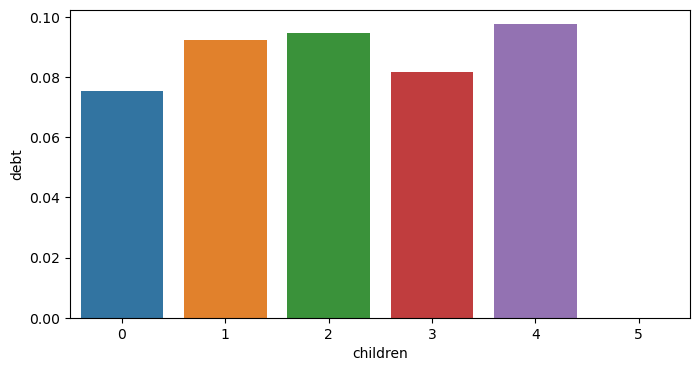

In [85]:
# Строим гистограмму
sb.barplot(x=data['children'], y=data['debt'], errorbar=None);


Видим, что нет явной зависимости уровня задолженности от количества детей. Но у нас нет картины для клиентов, у которых пять детей. Посмотрим на наши данные, создадим сводную таблицу, которая покажет нам сколько кредитов брали клиенты, сколько имеют задолженность и долю невозвратов.

In [89]:
# определим функцию, которая будет создавать сводную таблицу.
def data_pivot(variable):
    data_new = data.pivot_table(index=variable, values='debt', aggfunc=['count','sum','mean'])
    data_new.columns=['all_credits', 'all_debtors','share_debtors']
    display(data_new)

In [91]:
data_pivot('children')

,all_credits,all_debtors,share_debtors
children,,,
0,14091,1063,0.075438
1,4808,444,0.092346
2,2052,194,0.094542
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


Как видно из сводной таблицы больше всего кредитов берут люди, у которых нет детей. Меньше всего - люди у которых три и более детей. При этом доля должников значительно не меняется от количества детей у заемщика.

#### Выясним есть ли зависимость между семейным положением и возвратом кредита в срок

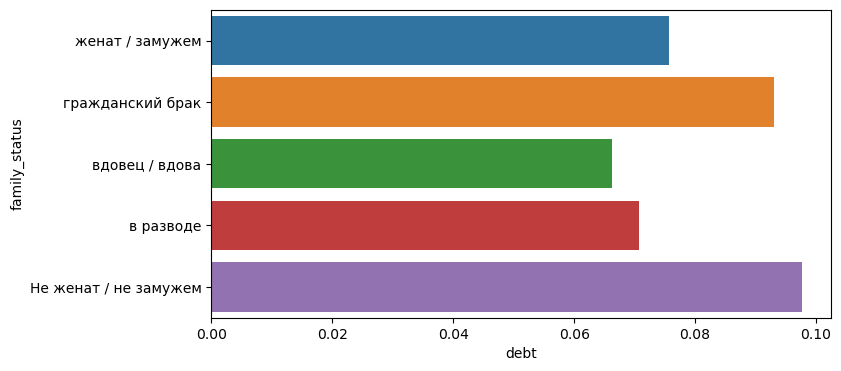

In [94]:
# Построим гистограмму для величин семейное положение и возврат кредита в срок.
sb.barplot(y=data['family_status'], x=data['debt'], errorbar=None);

Тут мы видим, что больше задолженность имеют люди не состоящие в браке или живущие гражданским браком.

Посмотрим на сводную таблицу.

In [97]:
data_pivot('family_status')

,all_credits,all_debtors,share_debtors
family_status,,,
Не женат / не замужем,2796,273,0.097639
в разводе,1189,84,0.070648
вдовец / вдова,951,63,0.066246
гражданский брак,4134,385,0.093130
женат / замужем,12261,927,0.075606


Как видим больше всего кредитов берут люди, находящиеся в браке, а вот задолженность по возврату кредита в срок выше у клиентов, живущих гражданским браком или же не женатые/не замужем. 

#### Посмотрим есть ли зависимость между уровнем дохода и возвратом кредита в срок

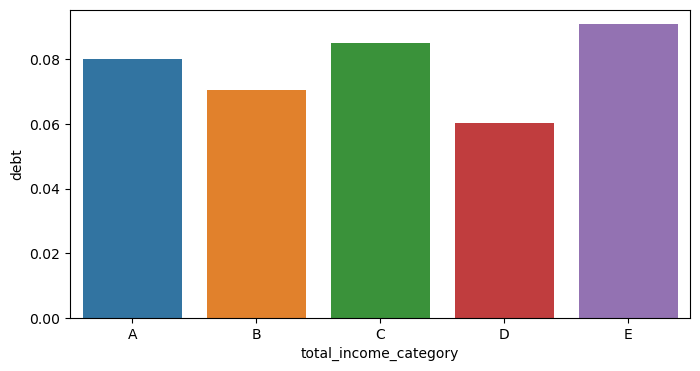

In [101]:
sb.barplot(x =data['total_income_category'], y= data['debt'], errorbar=None, order=['A', 'B', 'C', 'D','E']);

In [102]:
data_pivot('total_income_category')

,all_credits,all_debtors,share_debtors
total_income_category,,,
A,25,2,0.080000
B,5014,354,0.070602
C,15921,1353,0.084982
D,349,21,0.060172
E,22,2,0.090909


Наибольшее количество кредитов берут люди с доходом от 50 000 до 200 000 руб. Но они же и одни из лидеров по задолженностям.  В категориях с наименьшим доходом (меньше 30 000 руб.) и наиболее состоятельных выводы делать некорректно, так как данных очень мало. 

#### Влияют ли цели кредита на его возврат в срок

Проверм как цели кредита влияют на возврат его в срок. Для этого построим столбчатую диаграмму.

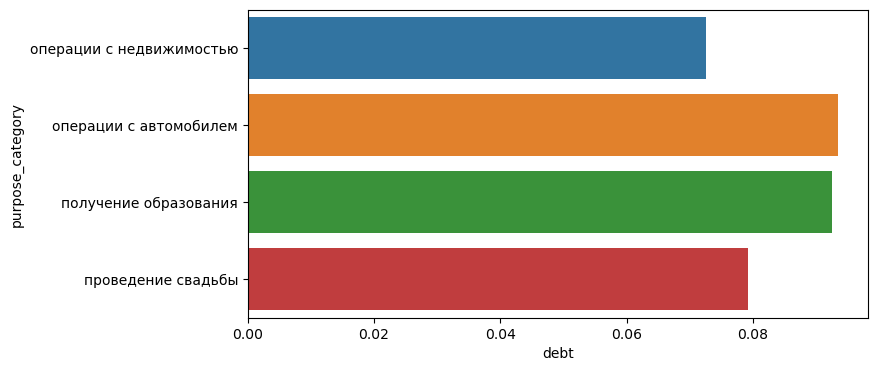

In [105]:
sb.barplot(y=data['purpose_category'], x=data['debt'], errorbar=None);

In [107]:
data_pivot('purpose_category')

,all_credits,all_debtors,share_debtors
purpose_category,,,
операции с автомобилем,4279,400,0.093480
операции с недвижимостью,10751,780,0.072551
получение образования,3988,369,0.092528
проведение свадьбы,2313,183,0.079118


Кредиты на операции с автомобилем и на получение образования имеют большую вероятность невозврата, в то время как кредит на операции с недвижимостью имеет самый маленький процент невозврата.

## Общий вывод

Нами было проведено исследование надежности заемщиков.
Были получены следующие данные о заемщиках банка:
    
    - количество детей
    - семейный статус
    - уровень образования
    - количество дней стажа
    - общий доход
    - возраст заемщика
    - пол
    - цель кредита
    
    
    
В данных были выявлены несколько проблем: 
    
    - пропуски данных в столбцах `days_employed` и `total_income`, отвечающих за стаж и общий доход
    
    Пропуски в `total_income` мы заменяли медианными значениями по каждому типу занятости, так как он сильно влияет на уровень дохода, и медианные значения меньше реагируют на выбросы данных, нежели среднее значение.  Также мы поступили со столбцом `days_employed`, в результате мы получили аномально большие значения для "пенсионеров" и "безработных", но исправлять эти данные мы не стали, они не повлияют на наше исследование.
    
    - в столбце `children` было два аномальных значения {-1, 20}
    
    Мы удалили такие строки, поскольку нет возможности исправить данные, не повлияв на другие значения.
    
    
    - в столбце `education` образование было заполнено разным регистром
    
    
    Мы перевели все записи в нижний регистр, в результате были выявлены дубликаты, которые мы удалили. 
    
Мы категоризировали уровень дохода заемщиков, разбив их на несколько категорий:
    * заемщики с уровнем дохода меньше 30 000 руб. - категория **E**
    * заемщики с уровнем дохода от 30 000 до 50 000 руб. - категория **D**
    * заемщики с уровнем дохода от 50 000 до 200 000 руб. - категория **C**
    * заемщики с уровнем дохода от 200 000 до 1 000 000 руб. - категория **B**
    * заемщики с уровнем дохода выше 1 000 000 руб. - категория **A**
    
Также все цели получения кредита мы сгруппировали в четыре группы "операции с недвижимостью", "получение образования", "проведение свадьбы", "операции с автомобилем".
    
Как показало наше исследование больше всего кредитов берут люди, не имеющие детей. При этом процент должников практически не меняется от количества детей, он варьируется от 7,5 до 9,5 %. Люди, имеющие пять детей, реже всего берут кредиты, и не имеют задолженностей по выплате.
    
Заемщики, живущие гражданским браком или не женатые/не замужем имеют больший процент невозврата (около 9,5 - 10 % ). Больше всего кредитов берут замужние/женатые люди, при этом количество должников среди них составляет около 7,5 %.
    
Большинство кредитов берутся на приобретение недвижимости, это и самый безопасный вид кредита для банка, доля невозврата равна почти 7,3 %, самые невозвратные это кредиты на приобретение автомобиля и получение образования (около 9,3 %).
    

Наибольшее количество кредитов берут люди с доходом от 50 000 до 200 000 руб. Но они же и одни из лидеров по задолженностям. Люди с наименьшим доходом (меньше 30 000 руб.) берут меньше всего кредитов, и, соответственно, процент невозврата у них будет высокий.   

Таким образом можно сказать, что количество детей, цели кредита, уровень дохода заемщика и семейный статус значительно не оказывает влияние на задолженность заемщика.   